# init

In [25]:
import utils.evaluation as eval_utils
import utils.model as model_utils
import torch
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.embed_concepts as embed_concepts
from tqdm.auto import tqdm
import os
import pickle
import torch.nn.functional as F

In [ ]:
FILE_CONFIG = {
    "path_all_concept": "D:/lora_finetune_eval/basic_info/concept_all.parquet",
    "path_is_a" : "D:/lora_finetune_eval/basic_info/graph_is_a_invariant.csv",
    "mapped_concept": "D:/lora_finetune_eval/basic_info/mapped_concepts_2025-04-01.csv",
    "training_triplet_idx": "D:/lora_finetune_eval/basic_info/training_anchor_idx_1M.parquet",

    "icd_snomed" : "D:/lora_finetune_eval/icd_snomed/",
    "benchmark": "D:/lora_finetune_eval/benchmark_jamil/",
    
    "embedding_save_path": "D:/lora_finetune_eval/embedding_by_model/",
    "syn_embedding_save_path": "D:/lora_finetune_eval/syn_embedding_by_model/",
    "new_exp_embedding_save_path": "D:/lora_finetune_eval/new_exp_embedding_by_model/",
    "embedding_icd_snomed_save_path": "D:/lora_finetune_eval/embedding_icd_snomed_by_model/",

    "result_save_path": "D:/lora_finetune_eval/result_by_model/",

}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_names = embed_concepts.MODEL_CONFIG.keys()

df_concept_all = pl.read_parquet(FILE_CONFIG["path_all_concept"])
df_concept_all_idx = set(df_concept_all["idx"].unique().to_list())

df_concept_train = pl.read_parquet(FILE_CONFIG["training_triplet_idx"])
df_concept_train_idx = set(df_concept_train["idx"].unique().to_list())

df_concept_test_idx = df_concept_all_idx - df_concept_train_idx
df_concept_test = list(df_concept_test_idx)

id2idx = dict(zip(df_concept_all["id"], df_concept_all["idx"]))

df_concept_test_fd = df_concept_all.filter(pl.col("idx").is_in(df_concept_test)).filter(pl.col("status") == "defined")["idx"].unique().to_list()


# task 1: retrieve label given expression

In [ ]:
mrrs_1 = []
models_1 = []
ranks_1 = {}
for model_key in model_names:

    if os.path.exists(FILE_CONFIG["embedding_save_path"] + model_key + ".pt"):
        print(f"Evaluating {model_key}...")
        embeddings = torch.load(FILE_CONFIG["embedding_save_path"] + model_key + ".pt")
        embedding_exp = embeddings["expressions_embeddings"]
        embedding_label = embeddings["labels_embeddings"]
        rank = eval_utils.top_k_array_by_batch(df_concept_test_fd, embedding_exp, embedding_label,device, 100)
        mrr_rank = eval_utils.compute_mmr(rank)
        mrrs_1.append(mrr_rank)
        models_1.append(model_key)
        ranks_1[model_key] = rank
        print(f"MRR: {mrr_rank}")

    else: 
        continue
    


In [ ]:
pl.DataFrame({"model": models_1, "mrr_1": mrrs_1}).write_csv(FILE_CONFIG["result_save_path"] + "mrr_1.csv")
with open(FILE_CONFIG["result_save_path"] + "ranks_1.pkl", 'wb') as f:
    pickle.dump(ranks_1, f)



# task 2,3

In [ ]:
mrrs_2_exp = []
mrrs_2_label = []

models_2 = []
ranks_2 = {}
for model_key in tqdm(list(model_names)):

    if  os.path.exists(FILE_CONFIG["syn_embedding_save_path"] + model_key + ".pt"):
        print(f"Evaluating {model_key}...")

        syn_embeddings = torch.load(FILE_CONFIG["syn_embedding_save_path"] + model_key + ".pt")
        embeddings = torch.load(FILE_CONFIG["embedding_save_path"] + model_key + ".pt")

        embedding_exp = embeddings["expressions_embeddings"]
        embedding_label = embeddings["labels_embeddings"]


        embedding_syn_idx = syn_embeddings["idx"]
        embedding_syn_matrix = syn_embeddings["expressions_embeddings"]

        # Determine test indices
        embedding_syn_test_idx = list(set(embedding_syn_idx).intersection(set(df_concept_test_fd)))

        # Compute rankings
        rank_w_label = eval_utils.top_k_array_syn_by_batch(embedding_syn_test_idx, embedding_syn_idx, embedding_syn_matrix, embedding_label, device=device)
        rank_w_exp = eval_utils.top_k_array_syn_by_batch(embedding_syn_test_idx, embedding_syn_idx, embedding_syn_matrix, embedding_exp, device=device)
        
        mrr_rank_exp = eval_utils.compute_mmr(rank_w_exp)
        mrr_rank_label = eval_utils.compute_mmr(rank_w_label)


        mrrs_2_exp.append(mrr_rank_exp)
        mrrs_2_label.append(mrr_rank_label)

        models_2.append(model_key)

        ranks_2[model_key] = {
        'expression': rank_w_exp,
        'label': rank_w_label
    }

        print(f"MRR: {mrr_rank_exp}")
        print(f"MRR: {mrr_rank_label}")

    else: 
        continue


In [ ]:
pl.DataFrame({"model": models_2, "mrr_2_exp": mrrs_2_exp,  "mrr_2_label": mrrs_2_label}).write_csv(FILE_CONFIG["result_save_path"] + "mrr_23.csv")
with open(FILE_CONFIG["result_save_path"] + "ranks_23.pkl", 'wb') as f:
    pickle.dump(ranks_2, f)


# task 4

In [ ]:
# task 4: hierarchical similarity
acc_4_exp = []
acc_4_label = []

models_4 = []


df_hierarchical_similarity = pd.read_table(FILE_CONFIG['benchmark'] + "hierarchical_similarity_benchmark.tsv")
df_hierarchical_similarity = pl.from_pandas(df_hierarchical_similarity)
df_hierarchical_similarity = df_hierarchical_similarity.select(pl.col("sctid").cast(pl.String), pl.col("close_sctid").cast(pl.String), pl.col("far_sctid").cast(pl.String))


for model_key in model_names:
    if os.path.exists(FILE_CONFIG["embedding_save_path"] + model_key + ".pt"):
        print(f"Evaluating {model_key}...")
    
        embeddings = torch.load(FILE_CONFIG["embedding_save_path"] + model_key + ".pt")
        # embedding = torch.load(EMBEDDING_PATH + model_name + ".pt", weights_only=True)
        embedding_exp = embeddings["expressions_embeddings"]
        embedding_label = embeddings["labels_embeddings"]

        accuracy_exp = eval_utils.compute_hierarchical_similarity(df_hierarchical_similarity, id2idx, embedding_exp)
        accuracy_label = eval_utils.compute_hierarchical_similarity(df_hierarchical_similarity, id2idx, embedding_label)

        acc_4_exp.append(accuracy_exp)
        acc_4_label.append(accuracy_label)

        models_4.append(model_key)

In [ ]:
pl.DataFrame({"model": models_4, "acc_4_exp": acc_4_exp,  "acc_4_label": acc_4_label}).write_csv(FILE_CONFIG["result_save_path"] + "acc_4.csv")


# task 5

In [ ]:
# Load and process the semantic composition benchmark
benchmark_file = FILE_CONFIG['benchmark'] +  "semantic_composition_benchmark.tsv"
df_semantic_composition = pd.read_table(benchmark_file)
df_semantic_composition = pl.from_pandas(df_semantic_composition)
df_semantic_composition = df_semantic_composition.select(
    pl.col("id_node"),
    pl.col("parents_ids"),
)

# Prepare the set of indices
list_idx_all = df_concept_all["idx"].unique().to_list()
list_idx_all_pre = df_concept_all.filter(pl.col("concept_type") == "SCT_PRE")["idx"].unique().to_list()
list_idx_all_post_set = set(list_idx_all) - set(list_idx_all_pre)

mrrs_5_exp = []
mrrs_5_label = []

models_5 = []
ranks_5 = {}

# Iterate over each model
for model_key in model_names:
    if os.path.exists(FILE_CONFIG["embedding_save_path"] + model_key + ".pt"):
        print(f"Evaluating {model_key}...")

        embeddings = torch.load(FILE_CONFIG["embedding_save_path"] + model_key + ".pt")
        embedding_exp = embeddings["expressions_embeddings"]
        embedding_label = embeddings["labels_embeddings"]

        rank_exp = eval_utils.compute_semantic_composition(df_semantic_composition, id2idx, embedding_exp, list_idx_all_post_set, device=device)
        rank_label = eval_utils.compute_semantic_composition(df_semantic_composition, id2idx, embedding_label, list_idx_all_post_set, device=device)

        mrr_rank_exp = eval_utils.compute_mmr(rank_exp)
        mrr_rank_label = eval_utils.compute_mmr(rank_label)

        mrrs_5_exp.append(mrr_rank_exp)
        mrrs_5_label.append(mrr_rank_label)

        models_5.append(model_key)

        # Update the existing_data dictionary
        ranks_5[model_key] = {
            "expression": rank_exp,
            "label": rank_label,
        }
    else: 
        continue

In [ ]:
pl.DataFrame({"model": models_5, "mrr_5_exp": mrrs_5_exp, "mrr_5_label": mrrs_5_label}) .write_csv(FILE_CONFIG["result_save_path"] + "mrr_5.csv")
with open(FILE_CONFIG["result_save_path"] + "ranks_5.pkl", 'wb') as f:
    pickle.dump(ranks_5, f)

# task 6

In [ ]:
mrrs_6_exp = []
mrrs_6_label = []

models_6 = []
ranks_6 = {}

for model_key in model_names:
    if os.path.exists(FILE_CONFIG["new_exp_embedding_save_path"] + model_key + ".pt"):

        print(f"Processing {model_key}...")

        embedding_new_exp = torch.load(FILE_CONFIG["new_exp_embedding_save_path"] + model_key + ".pt")
        embeddings = torch.load(FILE_CONFIG["embedding_save_path"] + model_key + ".pt")

        rank_label = eval_utils.top_k_exp_by_batch(embedding_new_exp["idx_true"], embedding_new_exp["new_expressions_embeddings"], embeddings["labels_embeddings"], batch_size=1000, device=device)
        rank_exp = eval_utils.top_k_exp_by_batch(embedding_new_exp["idx_true"], embedding_new_exp["new_expressions_embeddings"], embeddings["expressions_embeddings"], batch_size=1000, device=device)

        mrr_rank_exp = eval_utils.compute_mmr(rank_exp)
        mrr_rank_label = eval_utils.compute_mmr(rank_label)

        mrrs_6_exp.append(mrr_rank_exp)
        mrrs_6_label.append(mrr_rank_label)

        models_6.append(model_key)

        # Update the existing_data dictionary
        ranks_6[model_key] = {
            "expression": rank_exp,
            "label": rank_label,
        }
    else: 
        continue

In [65]:
pl.DataFrame({"model": models_6, "mrr_6_exp": mrrs_6_exp, "mrr_6_label": mrrs_6_label}).write_csv(FILE_CONFIG["result_save_path"] + "mrr_6.csv")
with open(FILE_CONFIG["result_save_path"] + "ranks_6.pkl", 'wb') as f:
     pickle.dump(ranks_6, f)


# task 7 ICD-SNOMED

In [40]:
def get_similarity_score_icd2snomed(icd_embeddings, snomed_embeddings, icd2snomed):
    """
    Calculate the similarity score between ICD and SNOMED embeddings.
    """
    cosine_sim_all = []
    for icd in icd2snomed.keys():
        icd_embedding = icd_embeddings[int(icd)]
        snomed_embedding = snomed_embeddings[icd2snomed[icd]]

        cosine_sim = F.cosine_similarity(icd_embedding, snomed_embedding.mean(dim=0), dim=0)
        cosine_sim_all.append(1-cosine_sim.item())
    return np.array(cosine_sim_all)

In [74]:
def get_similarity_score_snomed2icd(icd_embeddings, snomed_embeddings, snomed2icd):
    """
    Calculate the similarity score between ICD and SNOMED embeddings.
    """
    cosine_sim_all = []
    for icd in snomed2icd.keys():
        snomed_embedding = snomed_embeddings[int(icd)]
        icd_embedding = icd_embeddings[int(snomed2icd[icd][0])]

        cosine_sim = F.cosine_similarity(snomed_embedding, icd_embedding.mean(dim=0), dim=0)
        cosine_sim_all.append(1-cosine_sim.item())
    return np.array(cosine_sim_all)

In [41]:
snomed_info = pl.read_csv(FILE_CONFIG['icd_snomed']+ "snomed_info.csv")
icd_info = pl.read_csv(FILE_CONFIG['icd_snomed']+ "icd_info.csv")
with open(FILE_CONFIG['icd_snomed'] + "icd_snomed_mappings.pkl", "rb") as f:
    loaded_mappings = pickle.load(f)

# Access individual mappings like:
id2snomed = loaded_mappings["id2snomed"]
id2icd = loaded_mappings["id2icd"]
snomed2id = loaded_mappings["snomed2id"]
icd2id = loaded_mappings["icd2id"]
icd2snomed = loaded_mappings["icd2snomed"]
snomed2icd = loaded_mappings["snomed2icd"]


In [100]:
number_mapping = []
for snomed in snomed2icd.keys():
    number_mapping.append(len(snomed2icd[snomed]))

np.unique(number_mapping, return_counts=True)

(array([1, 2, 3, 4, 5]),
 array([42166,  3153,   221,    17,     2], dtype=int64))

In [102]:
42166 / len(number_mapping)

0.9255251432208784

In [78]:
models_sim_distance_s2i = {}
models_sim_distance_i2s = {}

for model_key in model_names:
    if os.path.exists(FILE_CONFIG["embedding_icd_snomed_save_path"] + model_key + ".pt"):
        print(f"Evaluating {model_key}...")
        embeddings = torch.load(FILE_CONFIG['embedding_icd_snomed_save_path'] + model_key + ".pt")
        embedding_icd = embeddings['icd_embeddings']
        embedding_snomed = embeddings['snomed_embeddings']
        sim_score_i2s = get_similarity_score_icd2snomed(embedding_icd, embedding_snomed, icd2snomed)
        sim_score_s2i = get_similarity_score_snomed2icd(embedding_icd, embedding_snomed, snomed2icd)

        models_sim_distance_s2i[model_key] = sim_score_s2i
        models_sim_distance_i2s[model_key] = sim_score_i2s
            
        


Evaluating finetune_1M...
Evaluating baseline...
Evaluating clinicalbert...
Evaluating bio_clinicalbert...
Evaluating e5_base...
Evaluating gte_base...
Evaluating sapbert...
Evaluating sapbert_lora_triplet8...
Evaluating sapbert_lora_triplet16...


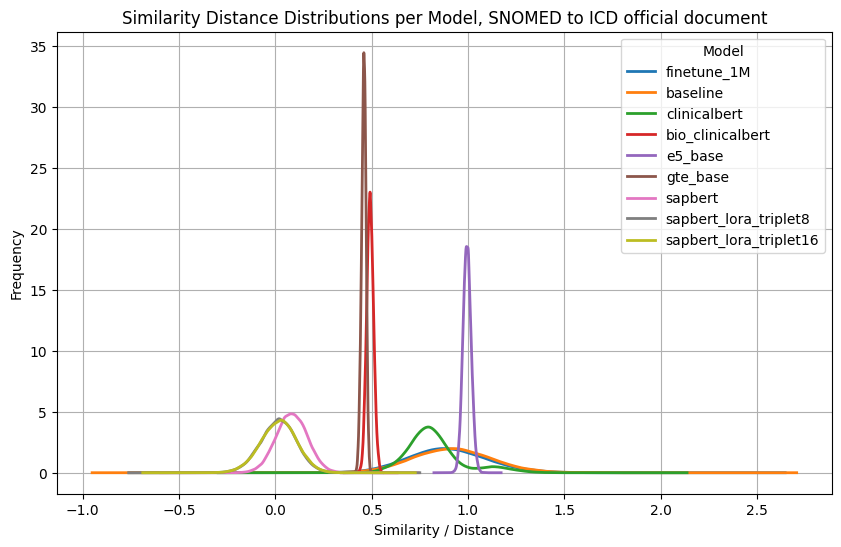

In [83]:
df_sim_distance = pd.DataFrame(models_sim_distance_s2i)
df_sim_distance.to_csv(FILE_CONFIG['result_save_path'] + "similarity distance SNOMED to ICD by model.csv")
df_sim_distance.plot(kind="kde", figsize=(10, 6), linewidth=2)
plt.title("Similarity Distance Distributions per Model, SNOMED to ICD official document")
plt.xlabel("Similarity / Distance")
plt.ylabel("Frequency")
plt.legend(title="Model")
plt.grid(True)
plt.show()


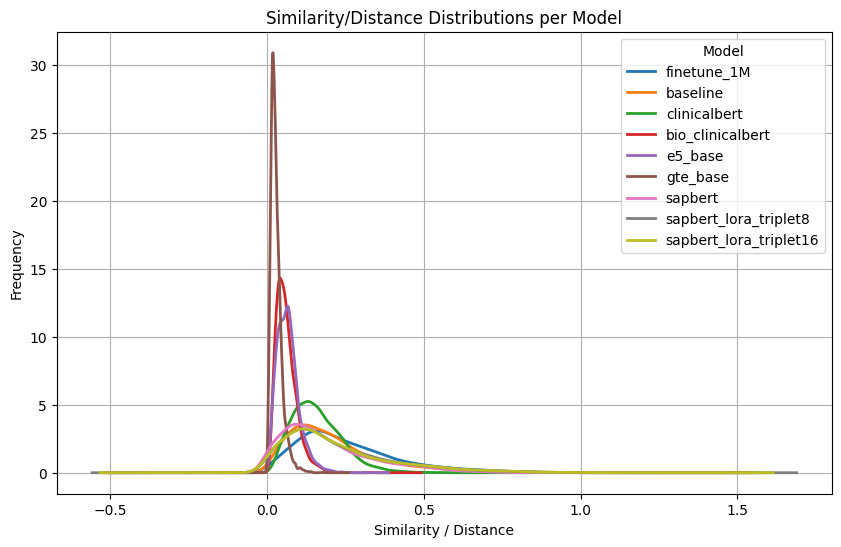

In [81]:
df_sim_distance = pd.DataFrame(models_sim_distance_i2s)
df_sim_distance.plot(kind="kde", figsize=(10, 6), linewidth=2)
plt.title("Similarity/Distance Distributions per Model")
plt.xlabel("Similarity / Distance")
plt.ylabel("Frequency")
plt.legend(title="Model")
plt.grid(True)
plt.show()

# Summarize the performance:

In [68]:
result_files = ["mrr_23", "acc_4", "mrr_5", "mrr_6"]
df_mrr1 = pl.read_csv(FILE_CONFIG['result_save_path'] + "mrr_1.csv")
df_final = df_mrr1.clone()
for file in result_files:
    df_new = pl.read_csv(FILE_CONFIG['result_save_path'] + file +".csv")
    df_final = df_final.join(df_new, on = "model")

df_final.sort(by = "mrr_1", descending=True).write_csv(FILE_CONFIG['result_save_path'] + "summary_performance.csv")